In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

sns.set_theme(style="whitegrid")

In [37]:
n_samples = 1000
n_features = 2
n_classes = 2
X = np.random.randn(n_samples, n_features) * 2
angles =  np.arctan(X[:, 1] / (X[:, 0] + 1e-5)) + np.pi * (X[:, 0] < 0)
condition1 = np.logical_and(angles > 0, angles < np.pi/8)
condition2 = np.logical_and(angles > np.pi/2, angles < 5*np.pi/8)
y = np.logical_or(condition1, condition2).astype(int)

# Sample data to ensure balanced classes

X = np.concatenate([X[y == 1], X[y == 0][::6]])
y = np.concatenate([y[y == 1], y[y == 0][::6]])

This is a synthetic two class data set to explain the construction of custom kernels. Which class a point belongs to is determined by the angle of its feature vector. Below we see, that the linear and the polnomial kernel have a hard time separating the two classes. The RBF kernel does a better job, but still does not understand the angular dependence.

Kernel: linear


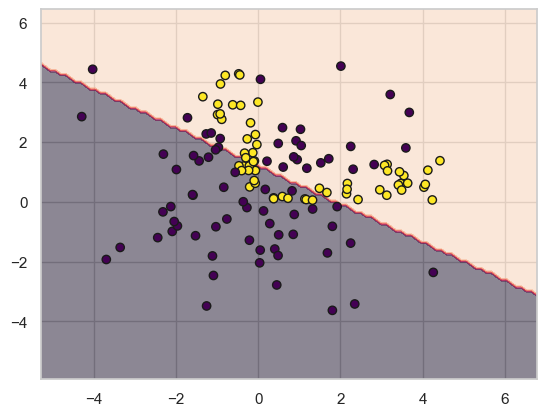

Kernel: poly


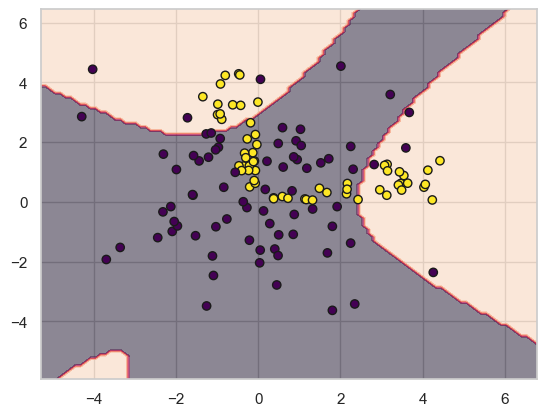

Kernel: rbf


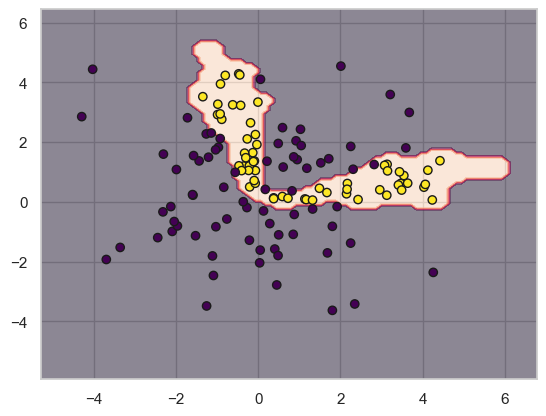

In [38]:
for kernel in ['linear', 'poly', 'rbf']:
    clf = SVC(kernel=kernel, gamma=5 if kernel == 'rbf' else 'auto')
    clf.fit(X, y)

    print(f"Kernel: {kernel}")
    disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
    scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')
    plt.show()

To model the angular dependence we use the cosine similarity kernel. The cosine of the angle between two vectors is the dot product of the two vectors divided by the product of their magnitudes, so the cosine similarity can be understood as the dot product between normalized feature vectors. Since the kernel replaces the dot product of the feature vectors, using the cosine similarity kernel is the same as using the linear kernel in a feature space, where the feature vectors are normalized.

This helps with the angular dependence, but is not sufficient for the complexity of the data sets.

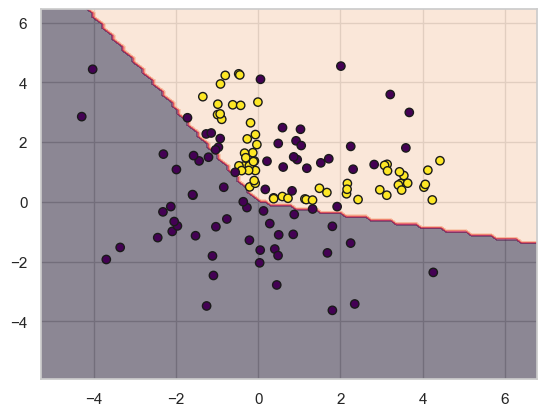

In [39]:
clf = SVC(kernel=cosine_similarity)
clf.fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

The RBF kernel uses the euclidean distance to measure the similarity between two points. If one assumes two vectors to be normalized the distance between them reduces to $2\cdot(1-\cos{\theta})$, where $\theta$ is the angle between the two vectors. So if we use $2\cdot(1-\mathrm{cosine\_similarity}(x, y))$ as the distance measure in the RBF kernel, we can model more complex angular dependencies.

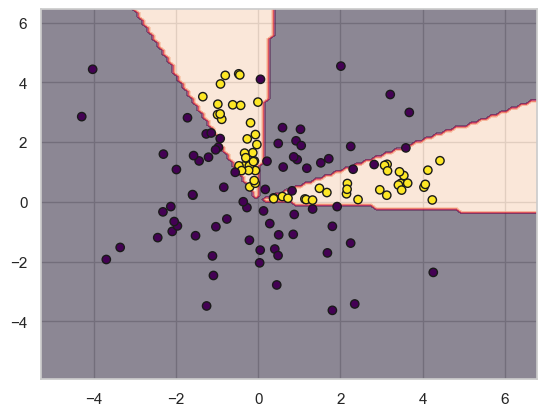

In [40]:
def cosine_rbf_kernel(X, Y=None, gamma=10):
    if Y is None:
        Y = X
    if gamma is None:
        gamma = 1 / X.shape[1]
    return np.exp(-gamma * 2 * (1 - cosine_similarity(X, Y)))

clf = SVC(kernel=cosine_rbf_kernel)
clf.fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

But if we now look at the following data set, which also has a strong angular dependence, the cosine_rbf_kernel no longer works well. 

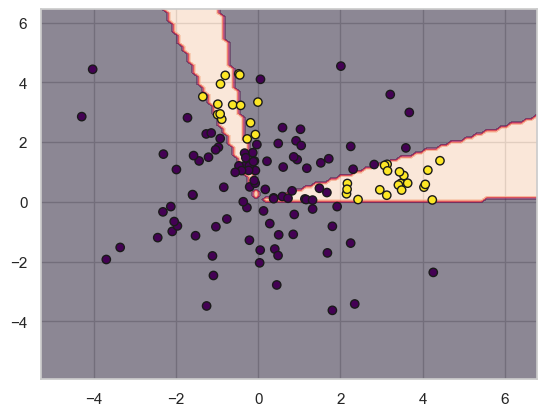

In [41]:
condition3 = np.linalg.norm(X, axis=1) > 2
y_new = np.logical_and(y, condition3).astype(int)

clf = SVC(kernel=cosine_rbf_kernel)
clf.fit(X, y_new)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y_new[::2], edgecolors='k', cmap='viridis')

To solve this, we introduce the generalized_cone_kernel, which is a product of the normal RBF kernel and the cosine_rbf_kernel.
The kernel is defined as:
$$
k(x, y) = \exp\{-\gamma \cdot [\alpha \cdot \|x-y\|^2 + (1-\alpha) \cdot 2\cdot(1-\mathrm{cosine\_similarity}(x, y))]\}
$$
The kernels are weighted by a parameter $\alpha$, which can be a function of $x$ and $y$ and has to be chosen according to the specific problem.

For our example we choose $\alpha = \exp\{-\beta (\|x\| + \|y\|)\}$, where $\beta$ is a hyperparameter. This causes the kernel to be more influenced by the cosine similarity for points with a large magnitude and more influenced by the euclidean distance for points with a small magnitude.

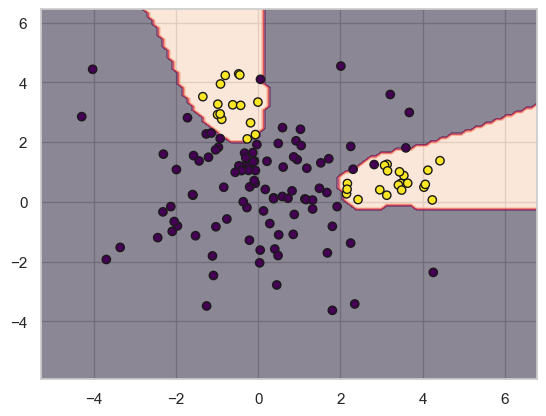

In [42]:
def generalized_cone_kernel(X, Y=None, gamma=10, beta=None):
    if Y is None:
        Y = X
    if gamma is None:
        gamma = 1 / X.shape[1]

    X_norms = np.linalg.norm(X, axis=1)
    Y_norms = np.linalg.norm(Y, axis=1)
    norm_grid = np.meshgrid(X_norms, Y_norms)
    sum_norms = norm_grid[0] + norm_grid[1]

    if beta is None:
        beta =  1 / np.std(sum_norms) 

    alpha = np.exp(-beta * sum_norms).T
    return np.exp(-gamma * (alpha * euclidean_distances(X, Y) + (1 - alpha) * 2 * (1 - cosine_similarity(X, Y))))

clf = SVC(kernel=generalized_cone_kernel, gamma=10)
clf.fit(X, y_new)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y_new[::2], edgecolors='k', cmap='viridis')

This example shows, how using knowledge about the data set, here the angular dependence, can help in constructing suitable kernels.